**Aim** - To perform Logistic Regression on Breast Cancer Dataset

---


**Dataset Description**
This breast cancer domain was obtained from the University Medical Centre, Institute of Oncology, Ljubljana, Yugoslavia. This data set includes 201 instances of one class and 85 instances of another class.  The instances are described by 9 attributes, some of which are linear and some are nominal.

---


**Result** -
SGD - R2 score = 94.97
Batch GD - R2 score = 92.46

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def sigmoid(z):
  return 1/(1 + np.exp(-z))

In [3]:
class LogisticClassifierSGD:
    def __init__(self, learning_rate=0.1, tolerance=1e-4, max_iter=500):
        # gradient descent parameters
        self.learning_rate = float(learning_rate)
        self.tolerance = float(tolerance)
        self.max_iter = int(max_iter)

        # how to construct a the design matrix
        self.add_intercept = True
        self.center = True
        self.scale = True

        self.training_loss_history = []

    def _design_matrix(self, X):
        if self.center:
            X = X - self.means
        if self.scale:
            X = X / self.standard_error
        if self.add_intercept:
            X = np.hstack([np.ones((X.shape[0], 1)), X])

        return X

    def fit_center_scale(self, X):
        self.means = X.mean(axis=0)
        self.standard_error = np.std(X, axis=0)

    def fit(self, X, y):
        self.fit_center_scale(X)

        # add intercept column to the design matrix
        n, k = X.shape
        X = self._design_matrix(X)

        # used for the convergence check
        previous_loss = -float('inf')
        self.converged = False

        # initialize parameters
        self.beta = np.zeros(k + (1 if self.add_intercept else 0))

        for i in range(self.max_iter):
            # Shuffle the dataset
            shuffle = np.random.permutation(len(y))
            X = X[shuffle, :]
            y = y[shuffle]

            # Stochastic gradient descent
            for j in range(n):
                x_j = X[j:j+1, :]
                y_j = y[j]
                y_hat = sigmoid(x_j @ self.beta)
                loss = -y_j * np.log(y_hat) - (1 - y_j) * np.log(1 - y_hat)
                self.training_loss_history.append(loss)

                # Update parameters
                residual = (y_hat - y_j).reshape((1, 1))
                gradient = x_j.T @ residual
                self.beta -= self.learning_rate * gradient.flatten()

            # Check convergence
            if i > 0 and abs(previous_loss - self.training_loss_history[-1]) < self.tolerance:
                self.converged = True
                break
            else:
                previous_loss = self.training_loss_history[-1]

        self.iterations = i + 1

    def predict_proba(self, X):
        # add intercept column to the design matrix
        X = self._design_matrix(X)
        return sigmoid(X @ self.beta)

    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)

In [4]:
class LogisticClassifierBATCHSGD:
    def __init__(self, learning_rate=0.1, tolerance=1e-4, max_iter=500, batch_size=32):
        # gradient descent parameters
        self.learning_rate = float(learning_rate)
        self.tolerance = float(tolerance)
        self.max_iter = int(max_iter)
        self.batch_size = batch_size

        # how to construct a the design matrix
        self.add_intercept = True
        self.center = True
        self.scale = True

        self.training_loss_history = []

    def _design_matrix(self, X):
        if self.center:
            X = X - self.means
        if self.scale:
            X = X / self.standard_error
        if self.add_intercept:
            X = np.hstack([np.ones((X.shape[0], 1)), X])

        return X

    def fit_center_scale(self, X):
        self.means = X.mean(axis=0)
        self.standard_error = np.std(X, axis=0)

    def fit(self, X, y):
        self.fit_center_scale(X)

        # add intercept column to the design matrix
        n, k = X.shape
        X = self._design_matrix(X)

        # used for the convergence check
        previous_loss = -float('inf')
        self.converged = False

        # initialize parameters
        self.beta = np.zeros(k + (1 if self.add_intercept else 0))
        momentum = self.beta * 0

        for i in range(self.max_iter):
            shuffle = np.random.permutation(len(y))
            X = X[shuffle, :]
            y = y[shuffle]

            # if batch_size does not evenly divide n, we'll have one more
            # batch of size less than batch_size at the end.
            runt = (1 if n % self.batch_size else 0)

            for batch_index in range(n // self.batch_size + runt):
                batch_slice = slice(
                    self.batch_size * batch_index,
                    self.batch_size * (batch_index + 1))
                X_batch = X[batch_slice, :]
                y_batch = y[batch_slice]

                y_hat = sigmoid(X_batch @ self.beta)

                # gradient descent
                residuals = (y_hat - y_batch).reshape((X_batch.shape[0], 1))
                gradient = (X_batch * residuals).mean(axis=0)
                momentum = 0.8 * momentum + self.learning_rate * gradient
                self.beta -= momentum

                # Store training loss
                self.training_loss_history.append(self.compute_loss(X, y))

            # Check convergence
            if i > 0 and abs(previous_loss - self.training_loss_history[-1]) < self.tolerance:
                self.converged = True
                break
            else:
                previous_loss = self.training_loss_history[-1]

        self.iterations = i + 1

    def compute_loss(self, X, y):
        y_hat = sigmoid(X @ self.beta)
        return np.mean(-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat))

    def predict_proba(self, X):
        # add intercept column to the design matrix
        X = self._design_matrix(X)
        return sigmoid(X @ self.beta)

    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)


In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split

In [6]:
# Load the breast cancer dataset
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

STOCHISTIC GRADIENT DESCENT

In [7]:
model_SGD = LogisticClassifierSGD()
model_SGD.fit(X_train, y_train)

In [8]:
p_hat_1 = model_SGD.predict_proba(X_test)
y_hat_1 = model_SGD.predict(X_test)
print('R2 Score of SDG:', r2_score(y_test, y_hat_1))
print('Accuracy Score of SDG:', accuracy_score(y_test, y_hat_1))

R2 Score of SDG: 0.9497354497354498
Accuracy Score of SDG: 0.9883040935672515


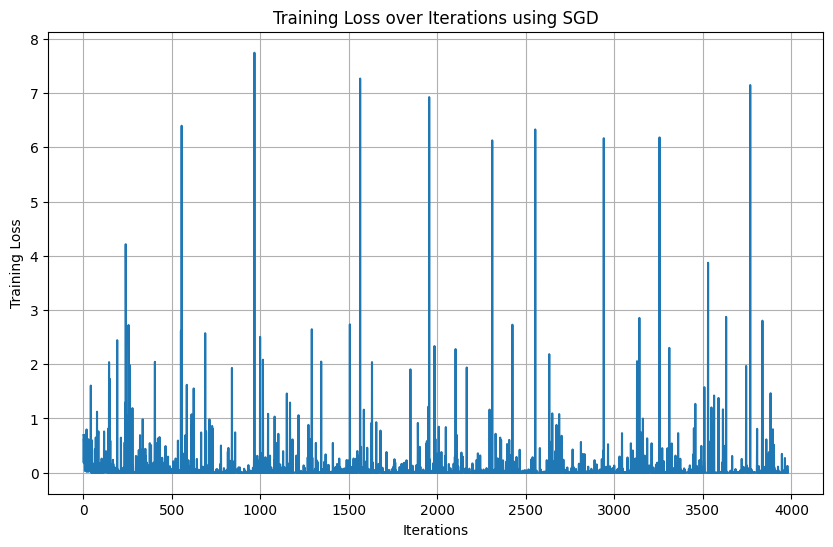

In [9]:
# Plot the training loss over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(model_SGD.training_loss_history) + 1), model_SGD.training_loss_history, linestyle='-')
plt.title('Training Loss over Iterations using SGD')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

BATCH STOCHISTIC GRADIENT DESCENT

In [10]:
model_BSDG = LogisticClassifierBATCHSGD(tolerance=1e-5, max_iter=500)
model_BSDG.fit(X_train, y_train)

In [11]:
p_hat_2 = model_BSDG.predict_proba(X_test)
y_hat_2 = model_BSDG.predict(X_test)
print('R2 Score of Batch SDG', r2_score(y_test, y_hat_2))
print('Accuracy Score of SDG:', accuracy_score(y_test, y_hat_1))

R2 Score of Batch SDG 0.9246031746031746
Accuracy Score of SDG: 0.9883040935672515


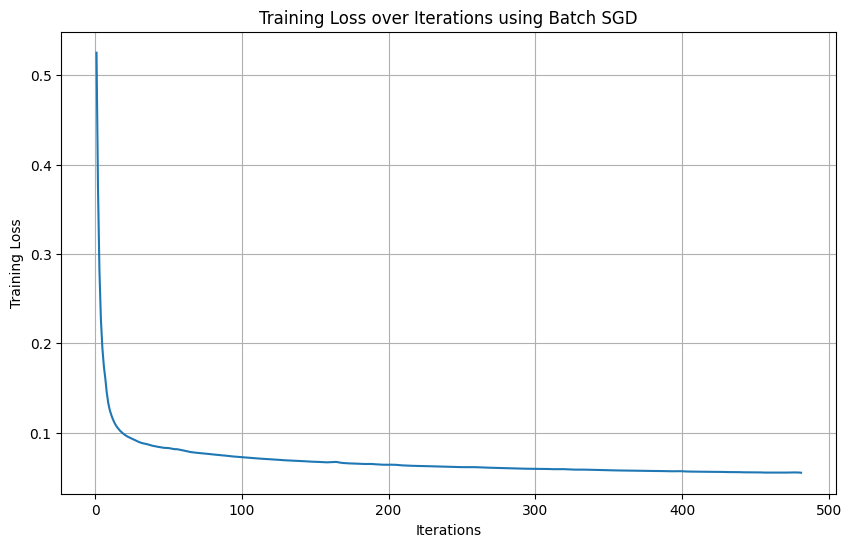

In [12]:
# Plot the training loss over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(model_BSDG.training_loss_history) + 1), model_BSDG.training_loss_history, linestyle='-')
plt.title('Training Loss over Iterations using Batch SGD')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()
